**Use Wide ResNet50-2 + Cutmix on Toys Department with image size resized to median height(229) and median width(213) along with ring loss** 

In [5]:
!nvidia-smi

Sat Jul 25 17:10:40 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN RTX           Off  | 00000000:04:00.0 Off |                  N/A |
| 43%   64C    P2   261W / 280W |  20648MiB / 24220MiB |     96%      Default |
+-------------------------------+----------------------+----------------------+
|   1  TITAN RTX           Off  | 00000000:05:00.0 Off |                  N/A |
| 82%   86C    P2   222W / 280W |  16998MiB / 24220MiB |     90%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [2]:
######### IMPORTING NECESSARY MODULES #########
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, TensorDataset
import sys
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data
from torchvision import transforms, datasets, models
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm


In [3]:
device = torch.device('cuda:4' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:4


**Dataloading Scheme**

In [4]:
trainlist = 'toys_data/toys_trainlist_ironman'
validlist ='toys_data/toys_validlist_ironman'

In [5]:
# Create a mapping of Unique product Ids to Labels(0 to 3713 classes)
# output = dictionary containing mapping of each upc to a label from (0 to 3713)  

with open(trainlist, mode = 'r') as f:
    
    Y=[]
    for line in f:
        path, UPC = line[:-1].split(',')

        Y.append(UPC)
        
prime_number_list = sorted(set(Y))

prime_number_dict = { prime_number_list[i] :i for i in range(0, len(prime_number_list) ) }

In [6]:
len(prime_number_dict)

3714

In [7]:
class mydataset():    

    def __init__(self, classification_list, prime_number_dict, name):

        super(mydataset).__init__()
        
        self.X = []
        self.Y = []
        
        with open(classification_list, mode = 'r') as f:
            
            for line in f:
                path, Prime_Number = line[:-1].split(',')

                self.X.append(path)
                self.Y.append(prime_number_dict[Prime_Number])
        

        if name == 'valid':
            self.transform = transforms.Compose([   transforms.RandomResizedCrop((229,213)),
                                                    transforms.ToTensor(),
                                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                    std=[0.229, 0.224, 0.225])
                                                ])
        else:
            self.transform = transforms.Compose([   transforms.RandomResizedCrop((229,213)),
                                                transforms.RandomHorizontalFlip(),
                                                transforms.ToTensor(),
                                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                    std=[0.229, 0.224, 0.225])
                                                                                            ])
    
    def __getitem__(self,index):
        
        image = self.X[index]        
        label = float(self.Y[index])
        
        image = (Image.open(image))
               
        image = self.transform(image)
        
        return image, torch.as_tensor(label).long()
        
  
    def __len__(self):
        return len(self.X)

In [8]:
# # #### Train Dataloader #### 
train_dataset = mydataset(trainlist, prime_number_dict, name='train')          
train_dataloader = data.DataLoader(train_dataset, shuffle= True, batch_size = 256, num_workers=16,pin_memory=True)


#### Validation Dataloader #### 
validation_dataset = mydataset(validlist, prime_number_dict, name='valid')         
validation_dataloader = data.DataLoader(validation_dataset, shuffle=True, batch_size = 128, num_workers=16,pin_memory=True)

**RESNET Architecture**

**Model Definition**

**Initialize the model**

In [9]:
# model = models.wide_resnet50_2(pretrained=False, num_classes = 3714)
model = models.wide_resnet101_2(pretrained=False, num_classes = 3714)

model = nn.DataParallel(model,device_ids=[4,5,6,7]).to(device)
model

DataParallel(
  (module): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(


**Helper function for Cutmix
https://arxiv.org/pdf/1905.04899v2.pdf**

In [10]:
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

**Training Method**

In [11]:
def train(model, data_loader, test_loader,beta, cutmix_prob, epochs):
    model.train()

    for epoch in range(epochs):
        avg_loss = 0.0
                
        
        for batch_num, (feats, target) in enumerate(data_loader):
            feats, target = feats.to(device), target.to(device)
            
            
            r = np.random.rand(1)
            if beta > 0 and r < cutmix_prob:
                # generate mixed sample
                lam = np.random.beta(beta, beta)
                rand_index = torch.randperm(feats.size()[0]).to(device)
                target_a = target
                target_b = target[rand_index]
                bbx1, bby1, bbx2, bby2 = rand_bbox(feats.size(), lam)
                feats[:, :, bbx1:bbx2, bby1:bby2] = feats[rand_index, :, bbx1:bbx2, bby1:bby2]
                # adjust lambda to exactly match pixel ratio
                lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (feats.size()[-1] * feats.size()[-2]))
                # compute output
                output = model(feats)
                loss = criterion(output, target_a) * lam + criterion(output, target_b) * (1. - lam)
            else:
                # compute output
                output = model(feats)
                loss = criterion(output, target)
            
            output = output.to(device)
            ringloss = ringloss_block(output)
            
            total_loss = loss + ringloss
            
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()
            
            avg_loss += total_loss.item()

            if batch_num % 100 == 99:
                print('loss', avg_loss/100)

            del feats
            del target
            del loss

        lr_scheduler.step()

        print('Epoch: ', epoch+1)

        print('training loss = ', avg_loss/len(data_loader))
        train_loss.append(avg_loss/len(data_loader))

        ## Check performance on validation set after an Epoch
        valid_loss, top1_acc, top5_acc = test_classify(model, test_loader)
        print('Validation Loss: {:.4f}\tTop 1 Validation Accuracy: {:.4f}\t Top 5 Validation Accuracy: {:.4f}'.format(valid_loss, top1_acc, top5_acc))
        v_loss.append(valid_loss)
        v_acc.append(top1_acc)

    
        
        
        #########save model checkpoint #########
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'Training_Loss_List':train_loss,
            'Validation_Loss_List':v_loss,
            'Validation_Accuracy_List': v_acc,
            'Epoch':epoch,
            'lr_scheduler': lr_scheduler.state_dict() 

            }, 'saved_model_checkpoints/Wide_ResNet101_2_cutmix_Median_Ringloss_Toys')


        
## Returns Loss, top1 and top5 accuracies on test/validation set
def test_classify(model, test_loader):
    model.eval()
    test_loss = []
    top1_accuracy = 0
    top5_accuracy = 0
    total = 0

    for batch_num, (feats, labels) in enumerate(test_loader):
        feats, labels = feats.to(device), labels.to(device)
        outputs = model(feats)
        
        loss = criterion(outputs, labels.long())
        test_loss.extend([loss.item()]*feats.size()[0])
        
        predictions = F.softmax(outputs, dim=1)
        
        _, top1_pred_labels = torch.max(predictions,1)
        top1_pred_labels = top1_pred_labels.view(-1)
        
        top1_accuracy += torch.sum(torch.eq(top1_pred_labels, labels)).item()
        
        _, top5_pred_labels = torch.topk(predictions, 5)
        
        for i in range(len(labels)):
            top5_accuracy += torch.sum(torch.eq(labels[i],top5_pred_labels[i])).item()
        
        total += len(labels)
        
        del feats
        del labels

    model.train()
    return np.mean(test_loss), top1_accuracy/total, top5_accuracy/total



**Ring Loss https://arxiv.org/pdf/1803.00130.pdf**

In [12]:
from torch.nn.parameter import Parameter

class RingLoss(nn.Module):
    def __init__(self, loss_weight=1.0):

        super(RingLoss, self).__init__()
        self.radius = Parameter(torch.Tensor(1)).to(device)
        self.radius.data.fill_(-1)
        self.loss_weight = loss_weight
        
    def forward(self, x):
        x = x.pow(2).sum(dim=1).pow(0.5)
        
        if self.radius.data[0] < 0: # Initialize the radius with the mean feature norm of first iteration
            self.radius.data.fill_(x.mean().data)
        
        # Divide the L2 Loss by the feature's own norm
        diff = (x.sub(self.radius.expand_as(x)) / (x.mean().detach().clamp(min=0.5)))
        diff_sq = torch.pow(torch.abs(diff), 2).mean()
        ringloss = diff_sq.mul_(self.loss_weight)

        return ringloss

**Hyperparameters**

In [13]:
# Loss Function
criterion = nn.CrossEntropyLoss()

ringloss_block = RingLoss(loss_weight=1.0)
 
# Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, weight_decay=1e-4, momentum=0.9)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size= 30, gamma = 0.1)


# Epochs
num_Epochs = 120

beta=1

cutmix_prob = 1

In [14]:
train_loss= []
v_loss = []
v_acc = []

**Train the model**

In [15]:
train(model, train_dataloader, validation_dataloader, beta, cutmix_prob, epochs = num_Epochs)

loss 8.230737867355346
loss 16.249988079071045
loss 24.216359720230102
loss 32.1519300699234
Epoch:  1
training loss =  8.0250440703498
Validation Loss: 9.0366	Top 1 Validation Accuracy: 0.0070	 Top 5 Validation Accuracy: 0.0236
loss 7.875431733131409
loss 15.741497149467468
loss 23.565227546691894
loss 31.368591227531432
Epoch:  2
training loss =  7.832643907335069
Validation Loss: 7.8892	Top 1 Validation Accuracy: 0.0149	 Top 5 Validation Accuracy: 0.0444
loss 7.706353116035461
loss 15.38668535709381
loss 23.018532009124755
loss 30.6150346660614
Epoch:  3
training loss =  7.642346399095324
Validation Loss: 7.0885	Top 1 Validation Accuracy: 0.0302	 Top 5 Validation Accuracy: 0.0851
loss 7.494592833518982
loss 14.925591173171997
loss 22.27978298664093
loss 29.63838122844696
Epoch:  4
training loss =  7.391636819839477
Validation Loss: 7.1819	Top 1 Validation Accuracy: 0.0530	 Top 5 Validation Accuracy: 0.1451
loss 7.2187112522125245
loss 14.376109943389892
loss 21.451891913414002
loss 

loss 13.422290270328523
Epoch:  36
training loss =  3.3586011282602946
Validation Loss: 2.6669	Top 1 Validation Accuracy: 0.5837	 Top 5 Validation Accuracy: 0.7544
loss 3.3166936266422273
loss 6.646537479162216
loss 10.012648125886917
loss 13.322536095380784
Epoch:  37
training loss =  3.3308240803082785
Validation Loss: 2.4569	Top 1 Validation Accuracy: 0.5880	 Top 5 Validation Accuracy: 0.7604
loss 3.310887908935547
loss 6.578628334999085
loss 9.894702653884888
loss 13.218190655708312
Epoch:  38
training loss =  3.3094067838456898
Validation Loss: 2.4787	Top 1 Validation Accuracy: 0.5886	 Top 5 Validation Accuracy: 0.7576
loss 3.2897596645355223
loss 6.589385297298431
loss 9.942360448837281
loss 13.223484040498734
Epoch:  39
training loss =  3.2907894955741033
Validation Loss: 2.7130	Top 1 Validation Accuracy: 0.5827	 Top 5 Validation Accuracy: 0.7521
loss 3.181848862171173
loss 9.794682657718658
loss 13.04238959312439
Epoch:  40
training loss =  3.270378999710083
Validation Loss: 2.

loss 2.8784223198890686
loss 5.698649114370346
loss 8.537776798009872
loss 11.354042038917541
Epoch:  72
training loss =  2.846988015174866
Validation Loss: 2.4705	Top 1 Validation Accuracy: 0.6109	 Top 5 Validation Accuracy: 0.7857
loss 2.8518401908874513
loss 5.666417469978333
loss 8.468075627088547
loss 11.283238993883133
Epoch:  73
training loss =  2.8197021770477293
Validation Loss: 2.5676	Top 1 Validation Accuracy: 0.6087	 Top 5 Validation Accuracy: 0.7840
loss 2.8529478812217715
loss 5.738258312940598
loss 8.508363480567931
loss 11.384101552963257
Epoch:  74
training loss =  2.8398703310224747
Validation Loss: 2.5147	Top 1 Validation Accuracy: 0.6124	 Top 5 Validation Accuracy: 0.7834
loss 2.782223261594772
loss 5.631371219158172
loss 8.539168448448182
loss 11.33712565422058
Epoch:  75
training loss =  2.8403213649325902
Validation Loss: 3.0683	Top 1 Validation Accuracy: 0.6022	 Top 5 Validation Accuracy: 0.7797
loss 2.8066623532772064
loss 2.8273331785202025
loss 5.682080132961

loss 5.435758644342423
loss 8.162634000778198
loss 10.93301275730133
Epoch:  108
training loss =  2.7403503404723275
Validation Loss: 3.0027	Top 1 Validation Accuracy: 0.6102	 Top 5 Validation Accuracy: 0.7834
loss 2.758113912343979
loss 5.525638123750687
loss 8.271732354164124
loss 11.029045766592025
Epoch:  109
training loss =  2.7590150729815166
Validation Loss: 2.6505	Top 1 Validation Accuracy: 0.6110	 Top 5 Validation Accuracy: 0.7854
loss 2.777918876409531
loss 5.512763206958771
loss 8.279929367303849
loss 11.08756085395813
Epoch:  110
training loss =  2.75927973429362
Validation Loss: 2.8589	Top 1 Validation Accuracy: 0.6123	 Top 5 Validation Accuracy: 0.7822
loss 2.7115087521076204
loss 5.499252198934555
loss 8.27434081196785
loss 11.079131090641022
Epoch:  111
training loss =  2.771735412809584
Validation Loss: 2.7291	Top 1 Validation Accuracy: 0.6111	 Top 5 Validation Accuracy: 0.7854
loss 2.7721251237392424
loss 5.5146655905246735
loss 8.331223212480545
loss 11.1241444766521

**Load saved model from checkpoint**

In [46]:
checkpoint = torch.load('saved_model_checkpoints/Wide_ResNet101_2_cutmix_Median_Ringloss_Toys')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
train_loss = checkpoint['Training_Loss_List'] 
v_loss = checkpoint['Validation_Loss_List']
v_acc = checkpoint['Validation_Accuracy_List']
epoch = checkpoint['Epoch']
lr_scheduler.load_state_dict(checkpoint['lr_scheduler'])



**Generate plots**

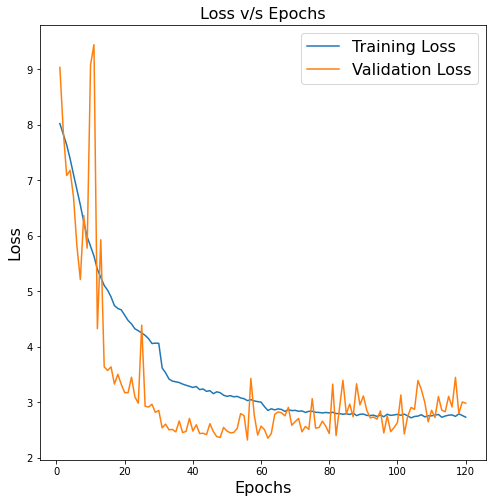

In [16]:
plt.figure(figsize=(8,8))
x = np.arange(1,121)
plt.plot(x, train_loss, label = 'Training Loss')
plt.plot(x, v_loss, label = 'Validation Loss')
plt.xlabel('Epochs', fontsize =16)
plt.ylabel('Loss', fontsize =16)
plt.title('Loss v/s Epochs',fontsize =16)
plt.legend(fontsize=16)

Text(0.5, 1.0, 'Validation Accuracy v/s Epochs')

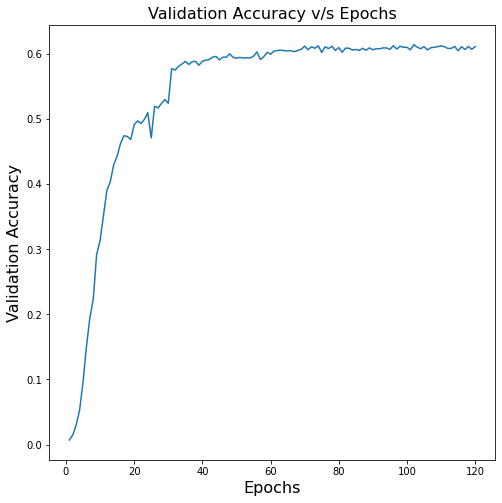

In [17]:
plt.figure(figsize=(8,8))
x = np.arange(1,121)
plt.plot(x, v_acc)
plt.xlabel('Epochs', fontsize =16)
plt.ylabel('Validation Accuracy', fontsize =16)
plt.title('Validation Accuracy v/s Epochs',fontsize =16)


In [45]:
t_loss,top1_t_acc, top5_t_acc =test_classify(model, train_dataloader)
print('Training Loss: {:.4f}\tTop 1 Training Accuracy: {:.4f}\t Top 5 Training Accuracy: {:.4f}'.format(t_loss, top1_t_acc, top5_t_acc))

Training Loss: 1.2796	Top 1 Training Accuracy: 0.7114	 Top 5 Training Accuracy: 0.9027


In [18]:
v_loss, top1_acc, top5_acc = test_classify(model, validation_dataloader)
print('Validation Loss: {:.4f}\tTop 1 Validation Accuracy: {:.4f}\t Top 5 Validation Accuracy: {:.4f}'.format(v_loss, top1_acc, top5_acc))

Validation Loss: 2.9917	Top 1 Validation Accuracy: 0.6053	 Top 5 Validation Accuracy: 0.7842
